# Final Project - Personalization Theory

Authors: *Bertrand Thia-Thiong-Fat, Jeremy Yao, Paul Doan*

# Deep Learning Model

In this notebook, we are going to build a deep learning model to predict the last ratings of the users in our dataset. The kind of Neural Network we are going to build is an AutoEncoder. 
<br>This choice has been made because AutoEncoders are **"simpler" models** and yet proved to be **very effective** in many personalization scenarios and competitions. 

We are going to build two models in particular:
* *one simple AutoEncoder*: we will train this model to reconstruct the missing ratings of a user based on the understanding of other ones who have similar preferences.
* *one Deep AutoEncoder*: similar to the previous model but with additional layers, we are going to train a Deep AutoEncoder. This model should be able to capture more complex trends and understand the data better than the previous model, making better predictions as a result. 

Finally, we are also going to investigate two types of dataset that we will describe later in this notebook.

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras import regularizers
from keras.optimizers import Adam, RMSprop
from keras import backend as K

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('dataset.csv').drop(columns='Unnamed: 0')
dataset.head()

,user_id,business_id,rating,date
0,keBv05MsMFBd0Hu98vXThQ,JDZ6_yycNQFTpUZzLIKHUg,5.0,2018-11-14 18:05:34
1,hZ_ElhGO3sQDVvM8ZrQetA,zfyGTLKOZuVY8aRoInyx9Q,4.0,2018-11-14 17:59:07
2,y5zqSJE-rFihsKmUZRbbRg,evdJO0v9rvVixieNEnaeJg,5.0,2018-11-14 17:57:01
3,ozUsNrw9QlEtz_JqN5PlMw,u1fa8SE-Rzea_xWbk_B-Zw,3.0,2018-11-14 17:49:52
4,sHY6JcgWOHLP4vR836Esmw,urSuLlkYXXI5uwtKIxl9ew,5.0,2018-11-14 17:25:32


In [3]:
num_users = len(dataset.user_id.unique())
num_business = len(dataset.business_id.unique())
print('There are {} active users. \nThey add up to a total of {} unique ratings. \nThere are {} different businesses'.format(dataset["user_id"].nunique(), dataset.shape[0], dataset["business_id"].nunique()))

There are 30750 active users. 
They add up to a total of 317153 unique ratings. 
There are 4996 different businesses


Here is the average global rating of our dataset: 

In [4]:
ratings_mean = dataset.groupby('user_id', as_index=False).mean()
average_global_rating = round(ratings_mean['rating'].mean(), 2)
print('Globl mean rating:', average_global_rating)

Globl mean rating: 3.8


### Splitting of the dataset into training, validation and testing set

Let us first split our dataset into a training set and a testing set. The testing set will be the last ratings we want to predict, while the training set will be the rest of our data:

In [5]:
dataset = dataset.sort_values('date', ascending=False)
test_last_ratings = dataset.drop_duplicates(subset='user_id', keep='first')
training_df = dataset[~(dataset.index).isin(test_last_ratings.index)]

We will now divide our train set into a validation set and a training set:

In [6]:
training_df = training_df.sort_values('date', ascending=False)
val_df = training_df.drop_duplicates(subset='user_id', keep='first')
training_df = training_df[~(training_df.index).isin(val_df.index)]

By doing this, we avoid reviews of a particular user all get agglomerated into either the training, validation or testing set. This could create bias in the analysis. For example, if the reviews of user A are only in the training set and none in testing or validation sets. The test loss score (RMSE) will be attributed a 0 for this user. On the other hand, if all reviews are in the test set, then there will be no review for this user during training time. This could cause the RMSE to be higher for this user. In our case, we know that we have at least 5 reviews per users. Hence, separating their last ratings ensure the users both appear in the training, validation and the testing sets. Also, this allows us to have a ratio of size $80-10-10$% between the train, validation and the test. 

In [7]:
print('Size of the training set:', training_df.shape[0])
print('Size of the validation set:', val_df.shape[0])
print('Size of the testing set:', test_last_ratings.shape[0])
print()
print('Ratio train/validation/test:', round(training_df.shape[0]/dataset.shape[0], 2), '/', \
     round(val_df.shape[0]/dataset.shape[0], 2),  '/',\
     round(test_last_ratings.shape[0]/dataset.shape[0], 2))

Size of the training set: 255653
Size of the validation set: 30750
Size of the testing set: 30750

Ratio train/validation/test: 0.81 / 0.1 / 0.1


# Let's define some helper functions

Let us define the functions we will use in this notebook to build our model and process our data:

In [8]:
# Plot the training curves of our deep learning model

def training_curves(history_model):
    plt.plot(history_model.history['masked_rmse_clip'])
    plt.plot(history_model.history['val_masked_rmse_clip'])
    plt.title('model masked_rmse_clip')
    plt.ylabel('masked_rmse_clip')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.grid()
    plt.show()
    # Training curve for the loss
    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.grid()
    plt.show()

* ### Description of the processing of our different sets

We are going to feed our AutoEncoder models with users-items matrices. They will be constructed as follows: 
* If the user have not seen an item, its rating will be set to 0 (or the global average rating of the total dataset)
* Otherwise, we just set the rating given bu the user. 

In [9]:
# Preprocessing the data for our Neural Network model

def dataPreprocessing(df, average = False):
    # Defining the list of distinct users and distinct businesses in our dataset
    unique_users = list(dataset.user_id.unique())
    unique_business = list(dataset.business_id.unique())
    
    # Initializing the users x items matrix
    matrix = np.zeros((num_users, num_business))
    matrix[:] = np.nan
    pivot = df.pivot_table(index='user_id', columns='business_id', values='rating')
    values = pivot.values
    
    # Filling the rating matrix with the data of df
    for i in range(len(pivot.columns)):
        k = unique_business.index(pivot.columns[i])
        matrix[:, k] = values[:, i]
    
    # Replacing the nan values by 0 or the average global rating 
    if average:
        matrix = np.nan_to_num(matrix, nan=average_global_rating)    
    else:
        matrix = np.nan_to_num(matrix, nan=0)
    return matrix

* ### Metrics used to train our models

Let us now define the loss function we are going to use to train our models. Since it does not make sense to predict zero in the user rating vector, we are going to minimize the Masked Mean Squared Error(MMSE). 
$$ MMSE = \frac{m_i * (r_i - y_i)^2}{\sum_{i=0}^n m_i} $$
where $r_i$ is the actual rating and $y_i$ is the reconstructed rating. $m_i$ is a mask function where $m_i =1$ if $r_i$ is non-zero else $m_i =0$.

In [10]:
def masked_mse(y_true, y_pred):
    # masked function
    mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
    # masked squared error
    masked_squared_error = K.square(mask_true * (y_true - y_pred))
    # average the error
    masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
    return masked_mse

The performance of our models will be measured by the Masked Root Mean Squared Error (MRMSE). Similar to MMSE, we only take into consideration the error where the rating is not zero in the test set. Also, we clipped the predicted rating with 1 as minimum and 5 as maximum so that the ratings make sense and are comparable to their ground truth.

In [11]:
def masked_rmse_clip(y_true, y_pred):
    # masked function
    mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
    # clipping the rating
    y_pred = K.clip(y_pred, 1, 5)
    # masked squared error
    masked_squared_error = K.square(mask_true * (y_true - y_pred))
    # square root
    masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
    return masked_mse

# First model: a simple AutoEncoder

## Implementation

The model we are first going to implement is a user-based AutoEncoder model for recommendations, which take the partially observed ratings vector of a user, project it into a low dimensional latent space and then reconstruct it back to the output space to predict the missing ratings. The library used to implement the models is Keras for simplicity.

In [12]:
def AE_model(X, reg, first_activation, last_activation):
    '''
    Parameters: 
        X: #_user X #_item matrix
        reg: L2 regularization parameter
        first_activation: activation function for first dense layer
        last_activation: activation function for second dense layer  
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', \
                         kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

* ### First training: training set filled with 0 when the item is not rated.

In [13]:
# Processing of the training, validation and testing set to the right format for our model

X_train = dataPreprocessing(training_df)
X_val = dataPreprocessing(val_df)
y_test = dataPreprocessing(test_last_ratings)

In [14]:
# Build model
AE = AE_model(X_train, 0.0005, 'elu', 'elu')
AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
AE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      (None, 4996)              0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               2498500   
_________________________________________________________________
UserScorePred (Dense)        (None, 4996)              2502996   
Total params: 5,001,496
Trainable params: 5,001,496
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
mc = ModelCheckpoint(filepath='AE.h5', monitor='val_loss', save_best_only=True)

hist_AE = AE.fit(x=X_train, y=X_train, \
                  epochs=100, \
                  batch_size=256, \
                  verbose = 1, validation_data=(X_train, X_val), callbacks=[es, mc])

We cleared the output of the training so that our notebook is easier to read. 
<br>The model performed **91 epochs and the running time was approximately 1,410.5s** (i.e. 23.5min - each epochs lasting around 15.5s in average).
<br> Here are the training curves obtained:

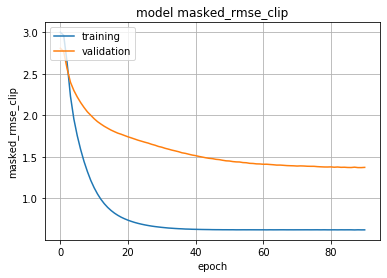

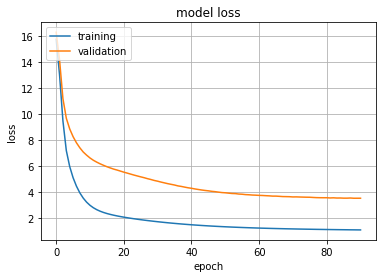

In [16]:
training_curves(hist_AE)

In [17]:
test_result = AE.evaluate(X_train, y_test)
print('Loss on the test set:', test_result[0])
print('masked_rmse_clip on the test set:', test_result[1])

30750/30750 [==============================] - 12s 378us/step
Loss on the test set: 3.5035558414459227
masked_rmse_clip on the test set: 1.3732531070709229


For this simple model, we can observe that **we get a lower RMSE than our baseline model i.e. more accurate predictions**. Let us see how the results of other experiments.

* ### Second training: training set filled with the average global rating when the item is not rated.

In this section, we will to train our AutoEncoder model with a modified training set, filled with the average global rating instead of 0 when the item is not rated. 
<br>This may allow a better reconstruction of the rating vector in the end and make the training easier - as the rating vector will not be reconstructed from scratch. Also, in order to compute our loss values, we only consider the ratings (different from 0) of the target vector (that we can find in the validation and testing set only), hence this will affect our metrics only if it deteriorates or improves the rating vector output.

In [18]:
X_train_average = dataPreprocessing(training_df, average=True)

In [19]:
# Build model
AE_average = AE_model(X_train_average, 0.0005, 'elu', 'elu')
AE_average.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
AE_average.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      (None, 4996)              0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               2498500   
_________________________________________________________________
UserScorePred (Dense)        (None, 4996)              2502996   
Total params: 5,001,496
Trainable params: 5,001,496
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mc = ModelCheckpoint(filepath='AE_average.h5', monitor='val_loss', save_best_only=True)

hist_AE_average = AE_average.fit(x=X_train_average, y=X_train, \
                  epochs=100, \
                  batch_size=256, \
                  verbose = 1, validation_data=(X_train_average, X_val), callbacks=[es, mc])

Again, we cleared the output of the training so that our notebook is easier to read. 
<br>The model performed **38 epochs and the running time was approximately 608s** (each epochs lasting around 16s in average).
<br> Here are the training curves obtained:

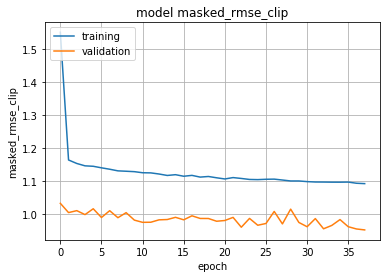

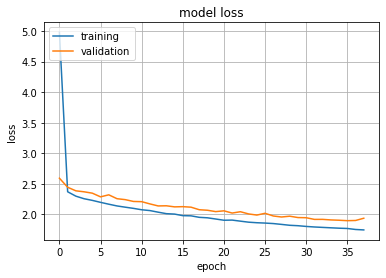

In [21]:
# Training curve for the masked_rmse_clip
training_curves(hist_AE_average)

In [22]:
test_result = AE_average.evaluate(X_train_average, y_test)
print('Loss on the test set:', test_result[0])
print('masked_rmse_clip on the test set:', test_result[1])

30750/30750 [==============================] - 13s 416us/step
Loss on the test set: 2.0012320515237203
masked_rmse_clip on the test set: 0.9613847732543945


This model performs **significantely better than the previous model**. The results are much more accurate.

## Conclusion

In this section, we trained a simple AutoEncoder with two datasets constructed differently. In the end, we obtained the best results with the training set where ratings of items not rated by a user were filled with the average global rating of the dataset. **The model converged much faster (training time reduced by a factor 2), and the results were more accurate as well.**

---

# Second model: a Deep AutoEncoder

## Implementation

The model we are now going to implement is a user-based Deep AutoEncoder model for recommendations. As previously, it will take the partially observed ratings vector of a user, project it into a low dimensional latent space and then reconstruct it back to the output space to predict the missing ratings. However, this time we are going to increase the number of layers of our model so that it is capable of understanding and treating the complexity of our data better.

In [23]:
def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Parameters: 
        X: #_user X #_item matrix
        layers: List, each element is the number of neuron for a layer
        reg: L2 regularization parameter
        activation: activation function for all dense layer except the last
        last_activation: activation function for the last dense layer
        dropout: dropout rate
        regularizer_encode: regularizer for encoder
        regularizer_decode: regularizer for decoder
        side_infor_size: size of the one hot encoding side information
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
        x = Dense(l, activation=activation, name='Encoder_Layer{}'.format(i), \
                  kernel_regularizer=regularizers.l2(regularizer_encode))(x)
        i = i+1
      
    # Latent Space
    x = Dense(layers[k], activation=activation, name='LatentSpace', \
              kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    for l in layers[k+1:]:
        i = i-1
        x = Dense(l, activation=activation, name='Decoder_Layer{}'.format(i), \
                  kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output
    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, \
                         name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

* ### First training: training set filled with 0 when the item is not rated.

In [24]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'elu'
last_activation = 'elu'
regularizer_encode = 0.001
regularizer_decode = 0.001

# Build model
Deep_AE = Deep_AE_model(X_train, layers, activation, last_activation, dropout, \
                        regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      (None, 4996)              0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1279232   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 4996)              1283972   
Total params: 2,826,116
Trainable params: 2,826,116
Non-trainable params: 0
_________________________________________________

In [ ]:
mc = ModelCheckpoint(filepath='Deep_AE.h5', monitor='val_loss', save_best_only=True)

hist_Deep_AE = Deep_AE.fit(x=X_train, y=X_train, \
                    epochs=100, \
                    batch_size=256, \
                    verbose=1, validation_data = (X_train, X_val), callbacks=[es, mc])

The model performed **63 epochs and the running time was approximately 882** (each epochs lasting around 14s in average).
<br> Here are the training curves obtained:

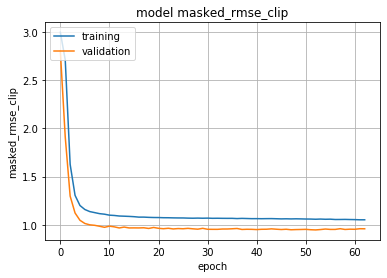

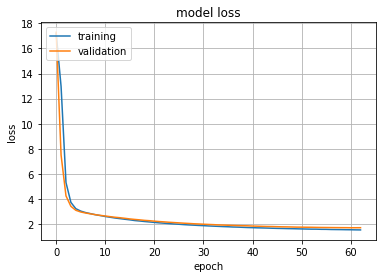

In [26]:
# Training curve for the masked_rmse_clip
training_curves(hist_Deep_AE)

In [27]:
test_result = Deep_AE.evaluate(X_train, y_test)
print('Loss on the test set:', test_result[0])
print('masked_rmse_clip on the test set:', test_result[1])

30750/30750 [==============================] - 11s 345us/step
Loss on the test set: 1.7642636760386026
masked_rmse_clip on the test set: 0.9755818843841553


Our Deep AutoEncoder model is able to get as good results as our previous best model, but with a training time a bit longer. However, we can observe that while the RMSE remain similar, the loss value is slightly better. We can thus deduce that this model is more accurate overall since the MSE is smaller.

* ### Second training: training set filled with the average global rating when the item is not rated.

We are now going to conduct the same experiment than previously, with the other training set we built.

In [28]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'elu'
last_activation = 'elu'
regularizer_encode = 0.001
regularizer_decode = 0.001

# Build model
Deep_AE_2 = Deep_AE_model(X_train_average, layers, activation, last_activation, dropout, \
                        regularizer_encode, regularizer_decode)
Deep_AE_2.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      (None, 4996)              0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1279232   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 4996)              1283972   
Total params: 2,826,116
Trainable params: 2,826,116
Non-trainable params: 0
_________________________________________________

In [ ]:
mc = ModelCheckpoint(filepath='Deep_AE_average.h5', monitor='val_loss', save_best_only=True)

hist_Deep_AE_2 = Deep_AE_2.fit(x=X_train_average, y=X_train, \
                    epochs=100, \
                    batch_size=256, \
                    verbose=1, validation_data = (X_train_average, X_val), callbacks=[es, mc])

The model performed **97 epochs and the running time was approximately 1,358s** (each epochs lasting around 14s in average).
<br> Here are the training curves obtained:

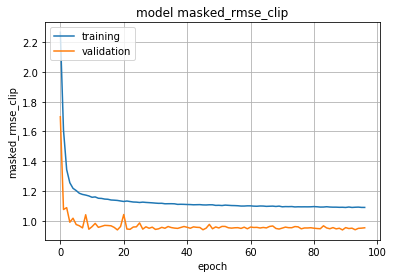

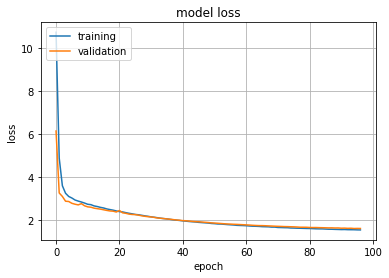

In [30]:
# Training curve for the masked_rmse_clip
training_curves(hist_Deep_AE_2)

In [31]:
test_result = Deep_AE_2.evaluate(X_train_average, y_test)
print('Loss on the test set:', test_result[0])
print('masked_rmse_clip on the test set:', test_result[1])

30750/30750 [==============================] - 10s 336us/step
Loss on the test set: 1.6665033574840886
masked_rmse_clip on the test set: 0.9731160998344421


The results with this dataset is not significantly better than the results of our previous experiment. **Overall, the performances are even less interesting since we obtain almost similar MSE and RMSE than previously but with a training time roughly 2 times superior.**

## Conclusion

We trained a Deep AutoEncoder with two datasets constructed differently. In the end, we obtained similar results with different initial inputs (different approach dealing with missing values), while the simple encoder was more sensitive to changes in the input. **Overall, the first experiment of the deep encoder converged faster (the training time was two times faster than the second one), and the evaluation metrics (MSE and RMSE) gave similar results.**

# General conclusion

In this notebook, we covered a simple AutoEncoder and a Deep AutoEncoder - much complex. We trained them using two different training sets. In the end, we are able to obtain quite similar results for the two models.
<br>The two first experiments show that **the simple AutoEncoder performs significantly better with a dense matrix: the training time is divided by 2 and the training error is significantly reduced as well**. 
<br>Regarding the two last experiments, we can conclude that **the Deep AutoEncoder is a more robust model that can handle sparse matrices very well. It can also deliver good results with difference in the input training set. The training time is slightly higher than the simple encoder, although the first AutoEncoder can achieve the same performance when trained with a dense matrix.** 